In [2]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
sys.path.append("..")
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# 以下是检查点路径
# 请在当前环境下 CMD 输入python -m visdom.server 或 visdom 启动监视器
# 数据处理现在已移至 emgDataprocess.ipynb
model_Dir = './/model//emgmk_cnn_0313//'
if not os.path.exists(model_Dir):
    os.makedirs(model_Dir)

ckpDir = './/ckp//emgmk_cnn_0313//oth//'
if not os.path.exists(ckpDir):
    os.makedirs(ckpDir)

ckpDir_auc = './/ckp//emgmk_cnn_0313//auc//'
if not os.path.exists(ckpDir_auc):
    os.makedirs(ckpDir_auc)

def get_current_time():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(get_current_time())

timeForSave = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

2022_03_19_19_21_58


In [4]:
# 以下是 visdom 监视窗口初始化，实现每次启用时重新加载，这里只写了 NameError 以防其他错误不能被发现
class visdom_account:
    def __init__(self):    
        self.port = 8097
        self.server = "http://localhost"
        self.base_url = "/"
        self.username = "admin"
        self.passward = "1234"
        self.evns = "train"
viz_acnt = visdom_account()
vislogDir = model_Dir+'vislog//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
def viz_init():
    try:
        viz
    except NameError:
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has started')
    else:
        viz.close()
        del viz
        print('last visdom session closed')
        viz = Visdom(env=viz_acnt.evns,log_to_filename=vislogDir+'vislog_'+timeForSave)
        print('visdom has restarted')
    return viz
viz = viz_init()

Setting up a new session...


visdom has started


In [33]:
# 自定义神经网络,CNN
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
# hdreshape = 1*32*5*12
hdreshape = 2
hdlayer_1 = 16
hdlayer_2 = 2
hdlayer_3 = 256
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,\
             kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,\
             kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, \
            kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=hdreshape, out_features=hdlayer_1)
        self.fc2 = nn.Linear(in_features=hdlayer_1, out_features=hdlayer_2)
        # self.fc3 = nn.Linear(in_features=hdlayer_2, out_features=hdlayer_3)
        self.out = nn.Linear(in_features=hdlayer_2, out_features=1)
        self.dr1 = nn.Dropout2d(0.2)

    def forward(self, t):
        # (1) input layer
        t = t
        # t = t.reshape(5,12)
        # t = t.unsqueeze(0)

        # (2) hidden conv layer
        # t = self.conv1(t)
        # t = F.relu(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (3) hidden conv layer
        # t = self.conv2(t)
        # t = F.relu(t)
        # t = self.dr1(t)
        # t = F.max_pool2d(t, kernel_size=2, stride=1)

        # (4) hidden linear layer
        # t = t.reshape(-1, hdreshape)
        # t = t.flatten(start_dim=0)
        # t = self.fc1(t)
        # t = F.relu(t)
        # t = self.fc2(t)
        # t = F.relu(t)
        # t = self.fc3(t)
        # t = F.relu(t)
        # t = self.dr1(t)

        # (5) output layer
        t = self.out(t)

        return t

net = Network()
# 打印网络，检查输入输出 shape是否正确
# print(net)
summary(net,(1,1,2),batch_size = 1,device = "cpu")
# 可视化结构，torchviz
sampleInput = torch.randn(1,1,1,2).requires_grad_(True)
sampleOutput = net(sampleInput)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [1, 1, 1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [5]:

dataarray = np.load('../data/220319emgsk/EMGSKdata_220321_free.npy',allow_pickle=True)
CNNdataset = dataarray.item()
print(type(CNNdataset))
# 加载自变量：
data_cyc = CNNdataset['data_cyc']
data_emg_rf_l = CNNdataset['data_emg_rf_l']
data_emg_lh_l = CNNdataset['data_emg_lh_l']
data_mf_rf_l = CNNdataset['data_mf_rf_l']
data_mf_bm_l = CNNdataset['data_mf_bm_l']
data_ka_l = CNNdataset['data_ka_l']

# 划分训练集与测试集
def DataSpliter(data):
    data_tr = []
    data_te = []
    for i in range(len(data)):
        if (i+1)%5 == 0:
            data_te.append(data[i,:])
        else:
            data_tr.append(data[i,:])
    data_tr = np.array(data_tr)
    data_te = np.array(data_te)
    return data_tr, data_te
tr_cyc,te_cyc = DataSpliter(data_cyc)
print(tr_cyc.shape,te_cyc.shape)
tr_mf_bm_l,te_mf_bm_l = DataSpliter(data_mf_bm_l)
tr_emg_rf_l,te_emg_rf_l = DataSpliter(data_emg_rf_l)
tr_emg_lh_l,te_emg_lh_l = DataSpliter(data_emg_lh_l)
tr_mf_rf_l,te_mf_rf_l = DataSpliter(data_mf_rf_l)
tr_ka_l,te_ka_l = DataSpliter(data_ka_l)

# 按需组合数据，这两函数其实可以合并成一个
def Data_conbine(data_1,data_2):
    data_train = []
    for i in range(len(data_1)):
        data_1_2 = np.hstack((data_1[i,:],data_2[i,:]))
        data_1_2 = data_1_2.flatten()
        data_train.append(data_1_2)
    data_train = np.array(data_train)
    return data_train

def establish_multi_timestep_data(data_X,data_X_2,data_Y,expect_time_length):
    dataset = []
    dataset_y = []
    if expect_time_length >0:
        length = len(data_X)-expect_time_length
        for i in range(length):
            data_1 = data_X[i:i+expect_time_length,:]
            data_1 = data_1.flatten()
            data_2 = data_X_2[i:i+expect_time_length,:]
            data_2 = data_2.flatten()
            data_12 = np.hstack((data_1,data_2))
            dataset.append(data_12)
            dataset_y.append(data_Y[i+expect_time_length-1,:])
        dataset = np.array(dataset)
        dataset_y = np.array(dataset_y)
    return dataset, dataset_y

data_12_tr = Data_conbine(tr_cyc,tr_emg_rf_l)
data_12_te = Data_conbine(te_cyc,te_emg_rf_l)
data_13_tr = Data_conbine(tr_cyc,tr_emg_lh_l)
data_13_te = Data_conbine(te_cyc,te_emg_lh_l)
data_123_tr = Data_conbine(data_12_tr,tr_emg_lh_l)
data_123_te = Data_conbine(data_12_te,te_emg_lh_l)

data_13_tr_5t,data_13_tr_5t_y = establish_multi_timestep_data(tr_cyc,tr_emg_lh_l,tr_mf_bm_l,5)
data_13_te_5t,data_13_te_5t_y = establish_multi_timestep_data(te_cyc,te_emg_lh_l,te_mf_bm_l,5)
print(data_13_tr_5t.shape,data_13_te_5t_y.shape)
# 转为 tensor 格式
data_12_tr = torch.from_numpy(data_12_tr)
data_12_te = torch.from_numpy(data_12_te)
data_13_tr = torch.from_numpy(data_13_tr)
data_13_te = torch.from_numpy(data_13_te)
data_123_tr = torch.from_numpy(data_123_tr)
data_123_te = torch.from_numpy(data_123_te)
tr_mf_rf_l = torch.from_numpy(tr_mf_rf_l)
te_mf_rf_l = torch.from_numpy(te_mf_rf_l)
tr_mf_bm_l = torch.from_numpy(tr_mf_bm_l)
te_mf_bm_l = torch.from_numpy(te_mf_bm_l)
tr_ka_l = torch.from_numpy(tr_ka_l)
te_ka_l = torch.from_numpy(te_ka_l)

data_12_tr = data_12_tr.to(torch.float32)
data_12_te = data_12_te.to(torch.float32)
data_13_tr = data_13_tr.to(torch.float32)
data_13_te = data_13_te.to(torch.float32)
data_123_tr = data_123_tr.to(torch.float32)
data_123_te = data_123_te.to(torch.float32)
tr_mf_rf_l = tr_mf_rf_l.to(torch.float32)
te_mf_rf_l = te_mf_rf_l.to(torch.float32)
tr_mf_bm_l = tr_mf_bm_l.to(torch.float32)
te_mf_bm_l = te_mf_bm_l.to(torch.float32)
tr_ka_l = tr_ka_l.to(torch.float32)
te_ka_l = te_ka_l.to(torch.float32)

data_13_tr_5t = torch.from_numpy(data_13_tr_5t).to(torch.float32)
data_13_te_5t = torch.from_numpy(data_13_te_5t).to(torch.float32)
data_13_tr_5t_y = torch.from_numpy(data_13_tr_5t_y).to(torch.float32)
data_13_te_5t_y = torch.from_numpy(data_13_te_5t_y).to(torch.float32)
print(data_12_te.shape,data_13_tr.shape,data_123_tr.shape)

<class 'dict'>
(81, 1) (20, 1)
(76, 10) (15, 1)
torch.Size([20, 2]) torch.Size([81, 2]) torch.Size([81, 3])


In [38]:
# CNN 训练
net = Network()
# 损失
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = torch.nn.MSELoss()
# criterion = nn.SmoothL1Loss()
# loss = torch.sqrt(criterion(x, y))
# 加载数据，设置优化器
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,shuffle=True)
# val_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=True)
# optimizer = torch.optim.Adam(net.parameters(),
#         lr=0.00002)
optimizer = torch.optim.Adam(net.parameters())
# lr_schedule = torch.optim.lr_scheduler.StepLR(\
#         optimizer, 1, gamma=0.8, last_epoch=-1)
# 初始化 visdom 
# viz.close()
# viz = viz_init()
vislogDir = './/vislog_ndata//cnn//'
if not os.path.exists(vislogDir):
    os.makedirs(vislogDir)
# viz = Visdom(env=viz_acnt.evns, log_to_filename=vislogDir+'vislog_'+get_current_time())
# vizx = 0
# viz.text('MONITOR: Show train process~~',win='Monitor', opts = {'title':'ProcessMonitor',},)

# total_test_acc = 0
# total_test_correct = 0
# totaltest = 0
# 训练过程
epoch_num = 4000000
net.to(device)
for epoch in range(epoch_num):

    # net.train()
    preds = net(data_13_tr.to(device)) 
    # trainloss = torch.sqrt(criterion(preds.to(device), data_train_MF.to(device)))
    trainloss = criterion(preds.to(device), tr_mf_bm_l.to(device))
    # trainloss = criterion(preds.to(device), data_train_MF.to(device))
    optimizer.zero_grad()
    trainloss.backward() # Calculate Gradients
    optimizer.step() # Update Weight

    if (epoch+1) % 1000 ==0:
        print(
            "epoch", epoch+1, 
            "MSE_tr:", float(trainloss),
        )

    




# checkpointPath_model = model_Dir+'c_final_'+'acc'+str(int(total_test_acc*10000))+'_'+timeForSave+'.pth'
checkpointPath_model = model_Dir+'kmmf_final_'+'_'+timeForSave+'.pth'
torch.save(net.state_dict(),checkpointPath_model)


epoch 1000 MSE_tr: 12189.5537109375
epoch 2000 MSE_tr: 12190.6328125
epoch 3000 MSE_tr: 12189.58984375
epoch 4000 MSE_tr: 12189.6416015625
epoch 5000 MSE_tr: 12191.4306640625
epoch 6000 MSE_tr: 12189.630859375


KeyboardInterrupt: 

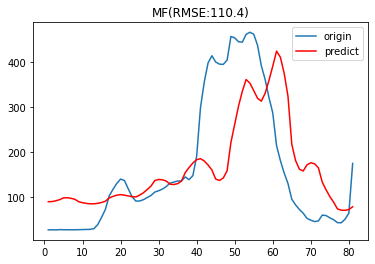

In [39]:

#对网络进行验证
show_x = data_13_tr
show_y = tr_mf_bm_l
show_l = 81
net.eval()
net.to('cpu')
predict = net(show_x)
# predict = predict.data.numpy()

MSE_show = criterion(predict, show_y)
predict = predict.data.numpy()
# 建立等差数列，（起始，终止，个数）
x = np.linspace(1,show_l,show_l)
column = 0
plt.title('MF(RMSE:'+str('%.5g' % torch.sqrt(MSE_show))+')')
plt.plot(x , show_y, label='origin')
plt.plot(x, predict, color='red', label='predict')
plt.legend()
plt.show()
